In [7]:
from pyspark.sql import SparkSession

import pandas as pd
import matplotlib.pyplot as plt


#abro una sesion con un nombre

#hay que tener cuidado que los workers de spark tengan la cantidad de Mb para ejecutar
spark = SparkSession\
.builder\
.config("spark.submit.deployMode", "client")\
.config("spark.executor.instances", "1")\
.config("spark.executor.memory", "1g")\
.config("spark.driver.memory", "1g")\
.config("spark.executor.memoryOverhead", "1g")\
.appName("latitud_longitud")\
.master("spark://bigdata-srv.fi.uncoma.edu.ar:7077")\
.getOrCreate()

spark.sparkContext._conf.getAll()  # ver la configuración

#podemos ver la ejecución de la aplicación en la pagina de Apache Spark http://IP_de_la_MV:8080/
#debe aparece como RUNNING 



[('spark.app.name', 'latitud_longitud'),
 ('spark.driver.port', '45847'),
 ('spark.sql.warehouse.dir',
  'file:/home/usuarioFAI/ejemplosPython/spark-warehouse'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.memory', '1g'),
 ('spark.app.id', 'app-20210514135202-0001'),
 ('spark.driver.host', '192.168.1.166'),
 ('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.instances', '1'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.startTime', '1621011121831'),
 ('spark.master', 'spark://bigdata-srv.fi.uncoma.edu.ar:7077'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.executor.memoryOverhead', '1g')]

In [8]:
# leo la fuente con hreader ture para que considere el esquema en la primer fila
df = spark.read.csv('../datasets/fuente2_covid.csv', header=True)

#seleccionar solo latitud y llongitus y quedarme con ellos en un nuevo dataframe
df_chico = df.select("latitude","longitude")
df_chico.show(5)

#con nulos
print(df_chico.count())
#sin nulos
df_chico.dropna("any").count()

df_chico2 = df_chico.withColumn("latitude", df_chico.latitude.cast("double")) \
                    .withColumn("longitude", df_chico.longitude.cast("double")) \
                    .dropna("any")

df_chico2.printSchema()


df_chico2.show(50)

+----------+------------------+
|  latitude|         longitude|
+----------+------------------+
|22.3650193|        114.133808|
|45.2977477|        11.6583815|
|   1.35346|          103.8151|
|      null|              null|
|  34.62931|113.46799999999999|
+----------+------------------+
only showing top 5 rows

441171
root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

+------------------+------------------+
|          latitude|         longitude|
+------------------+------------------+
|        22.3650193|        114.133808|
|        45.2977477|        11.6583815|
|           1.35346|          103.8151|
|          34.62931|113.46799999999999|
|          27.51356|          113.9029|
|          28.30755|          114.9732|
|          28.77693|          117.4692|
|          27.51128|          116.4344|
|          28.66149|          116.0257|
|          28.66149|          116.0257|
|          28.66149|          116.0257|
|          28.66149|          116

    latitude   longitude                    geometry
0  22.365019  114.133808  POINT (114.13381 22.36502)
1  45.297748   11.658382   POINT (11.65838 45.29775)
2   1.353460  103.815100   POINT (103.81510 1.35346)
3  34.629310  113.468000  POINT (113.46800 34.62931)
4  27.513560  113.902900  POINT (113.90290 27.51356)


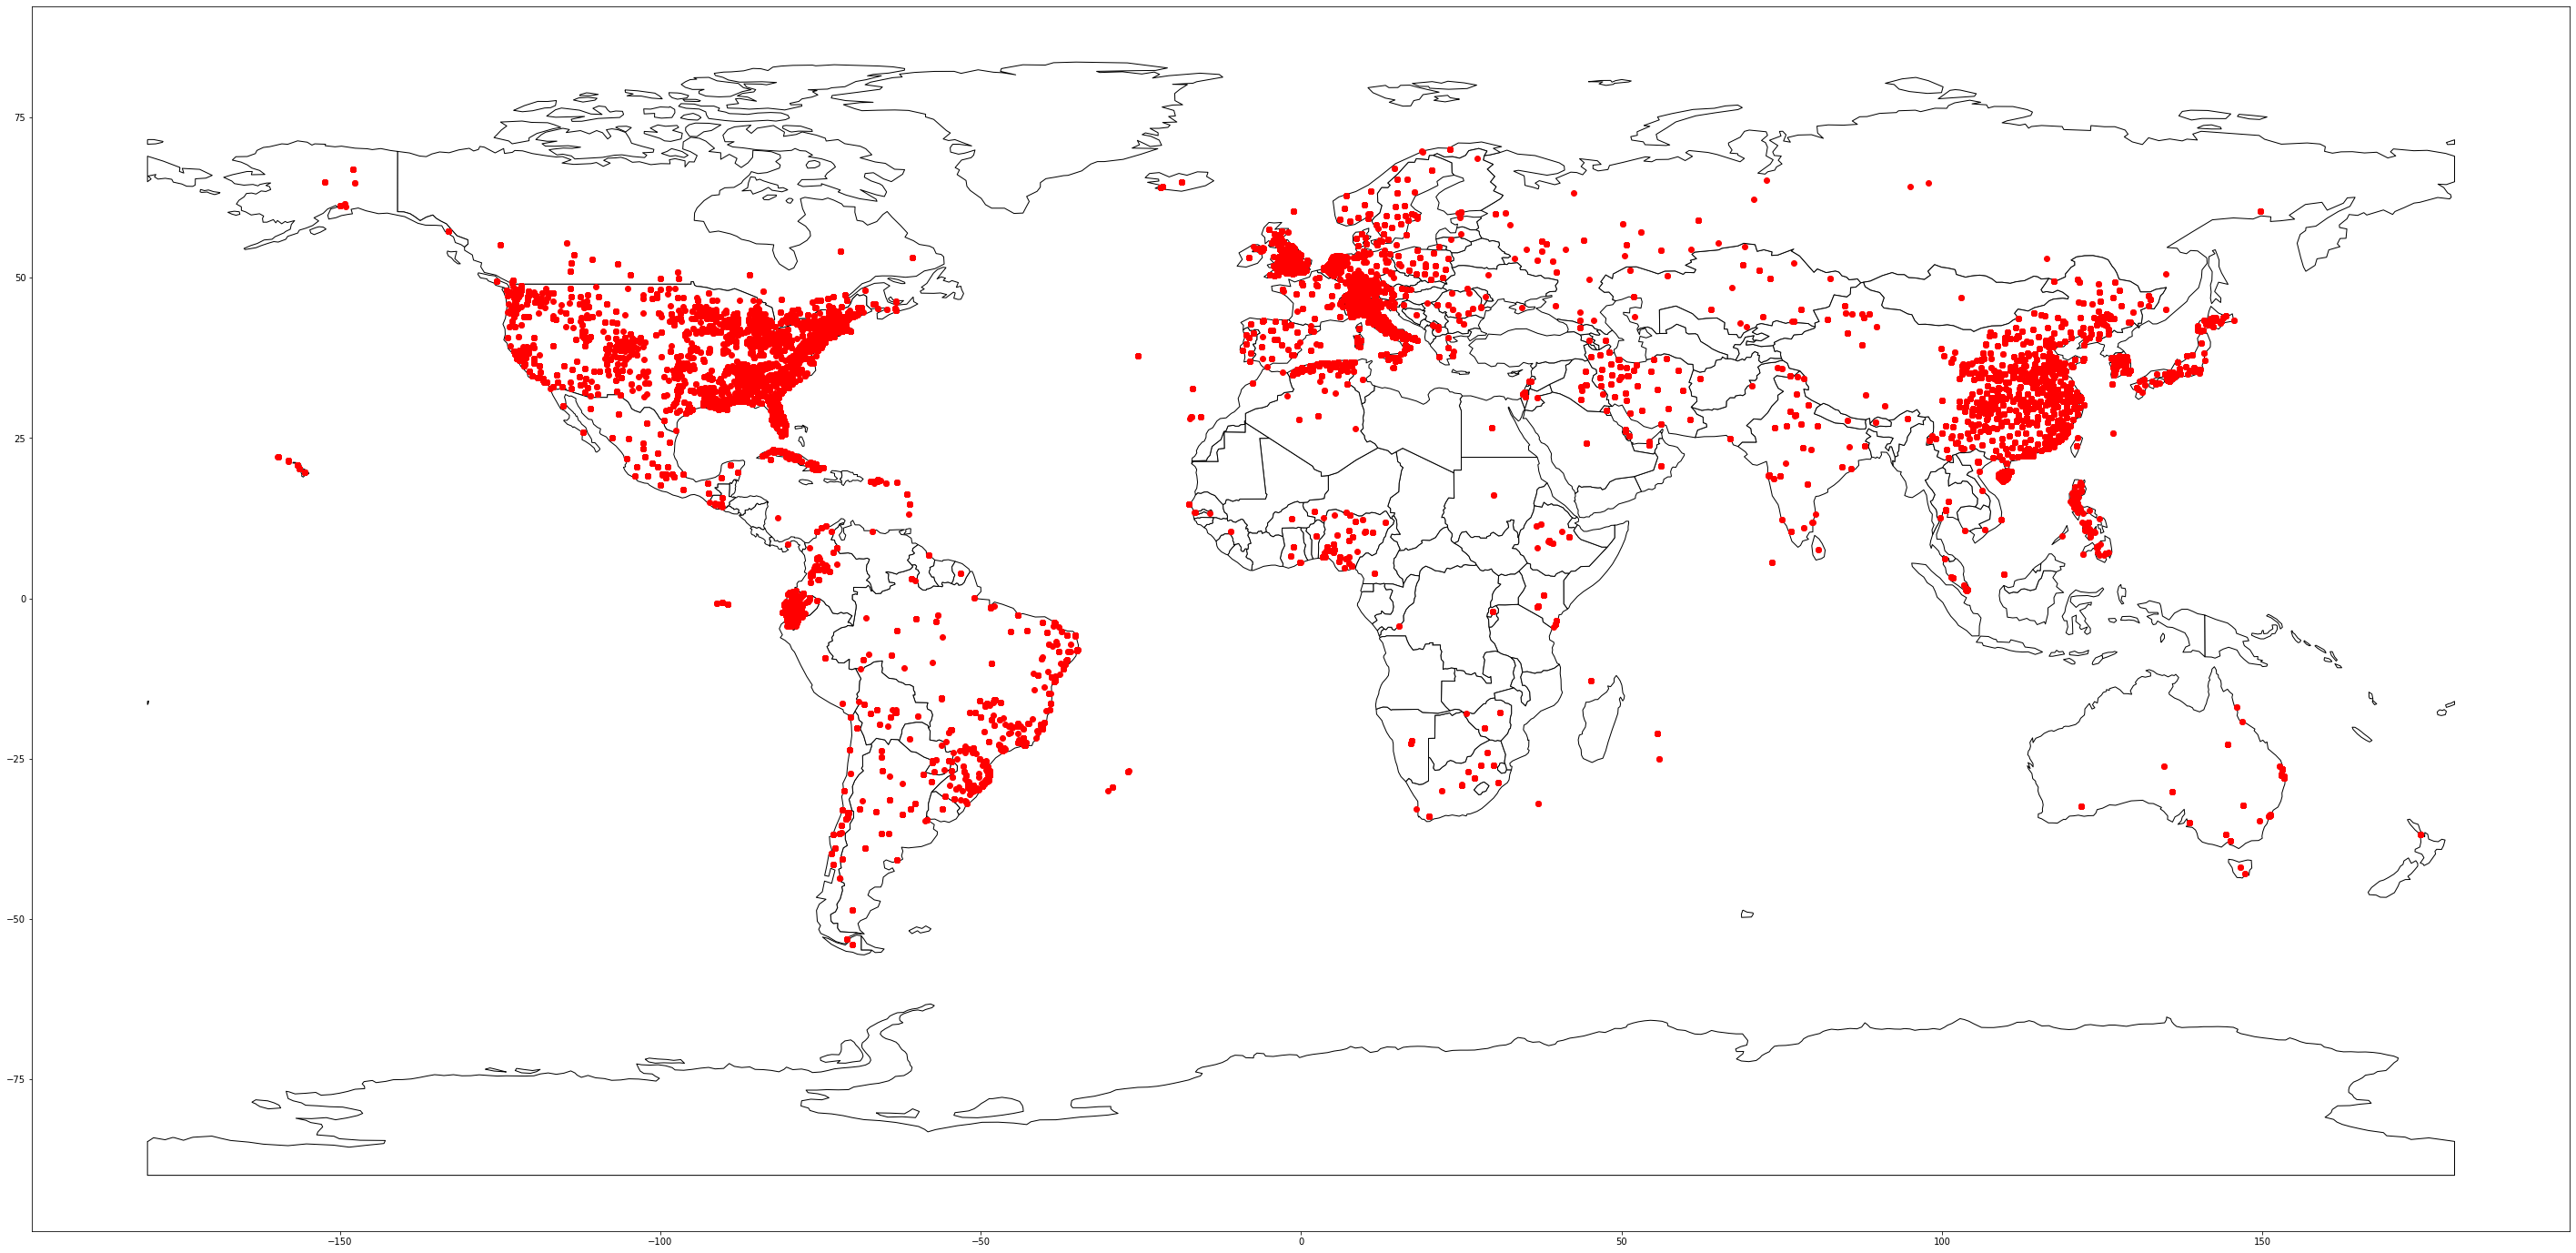

In [5]:
# usar la librería 
#si da error deben instalarla con el comando pip3 install geopandas desde el entorno de python
import geopandas


#convertir a pandas primero
pandas_df = df_chico2.toPandas()

gdf = geopandas.GeoDataFrame(pandas_df, geometry=geopandas.points_from_xy(pandas_df.longitude, pandas_df.latitude))

print(gdf.head())

#elegir mapa base
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#elegir colores
ax = world.plot(color='white', edgecolor='black',figsize=(50,30))

# plotear
gdf.plot(ax=ax, color='red')

plt.show()

In [9]:
#cierro la sesión y lo saco de RUNNING a FINISHED
spark.sparkContext.stop()